*author: Mai Linh Luong*
#Introduction
In this notebook the Self Organizing Map will be elaborated. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install minisom

In [ ]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

import pandas as pd

# Minisom library and module is used for performing Self Organizing Maps

from minisom import MiniSom
from sklearn.preprocessing import minmax_scale, scale

# 1.Merge Data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ICT Fontys/Semester 7/Project/P2 - Cleaned Own Version/tp2-owncleaned')
music = pd.read_csv('/content/drive/MyDrive/ICT Fontys/Groupprojects/Semester 7/Mini Company - FR Corp/1.Projects/Music/2.Exploratory Data Analysis/Datasets/TestRunnerTwo/music.csv')

In [ ]:
music.head(5)

,t,track_uri,paused,artist,track,context_uri,context,position,repeat_mode,shuffle,crossfade
0,2020-05-27 09:08:39.325963020,spotify:track:7B1h0Com19ccdjU8ukJdD4,False,Portico Quartet,Ruins,spotify:track:7B1h0Com19ccdjU8ukJdD4,NaN,0.000,off,False,False
1,2020-05-27 09:08:39.326946020,spotify:track:7B1h0Com19ccdjU8ukJdD4,False,Portico Quartet,Ruins,spotify:track:7B1h0Com19ccdjU8ukJdD4,NaN,0.007,off,False,False
2,2020-05-27 09:08:39.336856842,spotify:track:7B1h0Com19ccdjU8ukJdD4,False,Portico Quartet,Ruins,spotify:track:7B1h0Com19ccdjU8ukJdD4,NaN,0.018,off,False,False
3,2020-05-27 09:08:39.336945057,spotify:track:7B1h0Com19ccdjU8ukJdD4,False,Portico Quartet,Ruins,spotify:track:7B1h0Com19ccdjU8ukJdD4,NaN,0.018,off,False,False
4,2020-05-27 09:08:39.339579105,spotify:track:7B1h0Com19ccdjU8ukJdD4,False,Portico Quartet,Ruins,spotify:track:7B1h0Com19ccdjU8ukJdD4,NaN,0.023,off,False,False


In [ ]:
df.head(5)

,t,pronation_sa,braking_sa,impact_sa,contact_time_sa,flight_ratio_sa,strike_sa,power_sa,initial_foot,cadence_sa,speed_sa,frequency_sa,track_uri,position,start,pitches_mean,pitches_std,timbre_mean,timbre_std,section,duration_y,duration_confidence,loudness,tempo,tempo_confidence,key,key_confidence,mode,mode_confidence,time_signature,time_signature_confidence,danceability,energy,key_track,loudness_track,mode_track,speechiness,acousticness,instrumentalness,liveness,valence,tempo_track,duration_ms,time_signature_track
0,2020-06-07 18:46:18.758389950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left,NaN,NaN,NaN,spotify:track:4m5wf9g2zWzjb28HPqneS4,176.704,307.08386,0.281199,0.255676,49.914269,67.936256,11,14.14173,1.0,-28.34,176.505,0.064,0,0.0,1,0.0,4,1.0,0.56,0.89,4,-5.666,0,0.0513,0.00364,0.0876,0.364,0.484,176.018,320925,4
1,2020-06-07 18:46:18.758389950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left,NaN,NaN,NaN,spotify:track:4m5wf9g2zWzjb28HPqneS4,176.704,307.08386,0.281199,0.255676,49.914269,67.936256,11,14.14173,1.0,-28.34,176.505,0.064,0,0.0,1,0.0,4,1.0,0.56,0.89,4,-5.666,0,0.0513,0.00364,0.0876,0.364,0.484,176.018,320925,4
2,2020-06-07 18:46:18.758389950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left,NaN,NaN,NaN,spotify:track:4m5wf9g2zWzjb28HPqneS4,176.704,307.08386,0.281199,0.255676,49.914269,67.936256,11,14.14173,1.0,-28.34,176.505,0.064,0,0.0,1,0.0,4,1.0,0.56,0.89,4,-5.666,0,0.0513,0.00364,0.0876,0.364,0.484,176.018,320925,4
3,2020-06-07 18:46:18.758389950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left,NaN,NaN,NaN,spotify:track:4m5wf9g2zWzjb28HPqneS4,176.704,307.08386,0.281199,0.255676,49.914269,67.936256,11,14.14173,1.0,-28.34,176.505,0.064,0,0.0,1,0.0,4,1.0,0.56,0.89,4,-5.666,0,0.0513,0.00364,0.0876,0.364,0.484,176.018,320925,4
4,2020-06-07 18:46:18.758389950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left,NaN,NaN,NaN,spotify:track:4m5wf9g2zWzjb28HPqneS4,176.704,307.08386,0.281199,0.255676,49.914269,67.936256,11,14.14173,1.0,-28.34,176.505,0.064,0,0.0,1,0.0,4,1.0,0.56,0.89,4,-5.666,0,0.0513,0.00364,0.0876,0.364,0.484,176.018,320925,4


##  Merge music

In [ ]:
#first convert the 't' into datetime
df['t'] = pd.to_datetime(df['t'])
music['t'] = pd.to_datetime(music['t'])

In [ ]:
df_combined = pd.merge_asof(df, music, on='t', direction = 'backward')

In [ ]:
#check the data
df_combined.head(5)

,t,pronation_sa,braking_sa,impact_sa,contact_time_sa,flight_ratio_sa,strike_sa,power_sa,initial_foot,cadence_sa,speed_sa,frequency_sa,track_uri_x,position_x,start,pitches_mean,pitches_std,timbre_mean,timbre_std,section,duration_y,duration_confidence,loudness,tempo,tempo_confidence,key,key_confidence,mode,mode_confidence,time_signature,time_signature_confidence,danceability,energy,key_track,loudness_track,mode_track,speechiness,acousticness,instrumentalness,liveness,valence,tempo_track,duration_ms,time_signature_track,track_uri_y,paused,artist,track,context_uri,context,position_y,repeat_mode,shuffle,crossfade
0,2020-06-07 18:46:18.758389950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left,NaN,NaN,NaN,spotify:track:4m5wf9g2zWzjb28HPqneS4,176.704,307.08386,0.281199,0.255676,49.914269,67.936256,11,14.14173,1.0,-28.34,176.505,0.064,0,0.0,1,0.0,4,1.0,0.56,0.89,4,-5.666,0,0.0513,0.00364,0.0876,0.364,0.484,176.018,320925,4,spotify:track:4m5wf9g2zWzjb28HPqneS4,True,Ez Rollers,Badman Shoes - Serial Killaz Remix,spotify:user:bjwitkamp:playlist:6rnwtH8Wrd1Jkd...,Drum & Bass,176.704,off,False,False
1,2020-06-07 18:46:18.758389950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left,NaN,NaN,NaN,spotify:track:4m5wf9g2zWzjb28HPqneS4,176.704,307.08386,0.281199,0.255676,49.914269,67.936256,11,14.14173,1.0,-28.34,176.505,0.064,0,0.0,1,0.0,4,1.0,0.56,0.89,4,-5.666,0,0.0513,0.00364,0.0876,0.364,0.484,176.018,320925,4,spotify:track:4m5wf9g2zWzjb28HPqneS4,True,Ez Rollers,Badman Shoes - Serial Killaz Remix,spotify:user:bjwitkamp:playlist:6rnwtH8Wrd1Jkd...,Drum & Bass,176.704,off,False,False
2,2020-06-07 18:46:18.758389950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left,NaN,NaN,NaN,spotify:track:4m5wf9g2zWzjb28HPqneS4,176.704,307.08386,0.281199,0.255676,49.914269,67.936256,11,14.14173,1.0,-28.34,176.505,0.064,0,0.0,1,0.0,4,1.0,0.56,0.89,4,-5.666,0,0.0513,0.00364,0.0876,0.364,0.484,176.018,320925,4,spotify:track:4m5wf9g2zWzjb28HPqneS4,True,Ez Rollers,Badman Shoes - Serial Killaz Remix,spotify:user:bjwitkamp:playlist:6rnwtH8Wrd1Jkd...,Drum & Bass,176.704,off,False,False
3,2020-06-07 18:46:18.758389950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left,NaN,NaN,NaN,spotify:track:4m5wf9g2zWzjb28HPqneS4,176.704,307.08386,0.281199,0.255676,49.914269,67.936256,11,14.14173,1.0,-28.34,176.505,0.064,0,0.0,1,0.0,4,1.0,0.56,0.89,4,-5.666,0,0.0513,0.00364,0.0876,0.364,0.484,176.018,320925,4,spotify:track:4m5wf9g2zWzjb28HPqneS4,True,Ez Rollers,Badman Shoes - Serial Killaz Remix,spotify:user:bjwitkamp:playlist:6rnwtH8Wrd1Jkd...,Drum & Bass,176.704,off,False,False
4,2020-06-07 18:46:18.758389950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left,NaN,NaN,NaN,spotify:track:4m5wf9g2zWzjb28HPqneS4,176.704,307.08386,0.281199,0.255676,49.914269,67.936256,11,14.14173,1.0,-28.34,176.505,0.064,0,0.0,1,0.0,4,1.0,0.56,0.89,4,-5.666,0,0.0513,0.00364,0.0876,0.364,0.484,176.018,320925,4,spotify:track:4m5wf9g2zWzjb28HPqneS4,True,Ez Rollers,Badman Shoes - Serial Killaz Remix,spotify:user:bjwitkamp:playlist:6rnwtH8Wrd1Jkd...,Drum & Bass,176.704,off,False,False


# 2.Normal Distribution Danceability

### 2.1.Calculating the danceability category

In [ ]:
#Make distribution of danceability
df_danceability = df[['danceability']]

In [ ]:
df_danceability.describe()

,danceability
count,101121.000000
mean,0.790287
std,0.040706
min,0.560000
25%,0.759000
50%,0.783000
75%,0.823000
max,0.844000


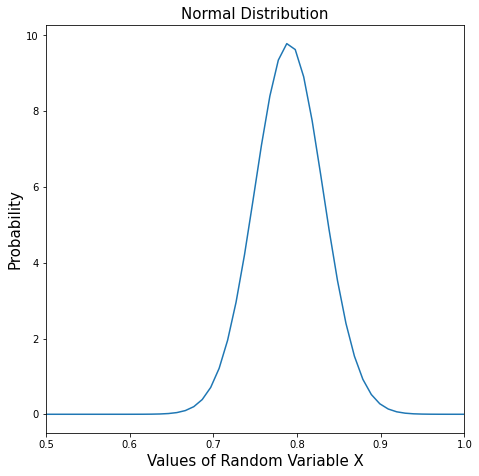

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
#
# Create a standard normal distribution with mean as 0 and standard deviation as 1
#
mu = 0.790287
std = 0.040706
snd = stats.norm(mu, std)
#
# Generate 100 random values between -5, 5
#
x = np.linspace(0, 1, 100)
#
# Plot the standard normal distribution for different values of random variable
# falling in the range -5, 5
#
plt.figure(figsize=(7.5,7.5))
plt.plot(x, snd.pdf(x))
plt.xlim(0.5, 1)
plt.title('Normal Distribution', fontsize='15')
plt.xlabel('Values of Random Variable X', fontsize='15')
plt.ylabel('Probability', fontsize='15')
plt.show()

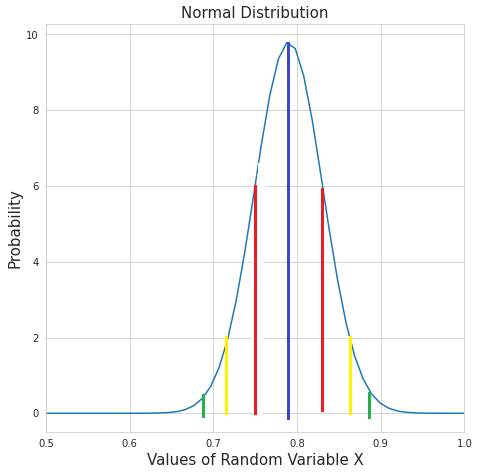

Calculating the normal distribution, I've come to the conclusion to categorize the following categories depening on danceability. 

| values | label| 
| --- | ---| 
| < 0.668169 | very low danceability| 
| 0.668169 - 0.708875 | not so danceable|
| 0.708875 - 0.790287 | danceable | 
| 0.790287 - 0.830993 | high danceabilty| 
| 0.830993 - 0.871699 | very danceable | 
| 0.871699 > | extreme danceability| 

### 2.2.Creating a column with category

In [ ]:
# create a list of our category
category = [
    (df_combined['danceability'] <= 0.668169),
    (df_combined['danceability'] > 0.668169) & (df_combined['danceability'] <=  0.708875),
    (df_combined['danceability'] > 0.708875) & (df_combined['danceability'] <=  0.790287),
    (df_combined['danceability'] > 0.790287) & (df_combined['danceability'] <= 0.830993), 
    (df_combined['danceability'] > 0.830993) & (df_combined['danceability'] <= 0.871699), 
    (df_combined['danceability'] > 0.871699)
    ]

# create a list of the values we want to assign for each condition
values = ['very low danceability', 'not so danceable', 'danceable', 'high danceability', 'very danceable', 'extreme danceability']

# create a new column and use np.select to assign values to it using our lists as arguments
df_combined['dancecategory'] = np.select(category, values)

# display updated DataFrame
df_combined.head()

,t,pronation_sa,braking_sa,impact_sa,contact_time_sa,flight_ratio_sa,strike_sa,power_sa,initial_foot,cadence_sa,speed_sa,frequency_sa,track_uri_x,position_x,start,pitches_mean,pitches_std,timbre_mean,timbre_std,section,duration_y,duration_confidence,loudness,tempo,tempo_confidence,key,key_confidence,mode,mode_confidence,time_signature,time_signature_confidence,danceability,energy,key_track,loudness_track,mode_track,speechiness,acousticness,instrumentalness,liveness,valence,tempo_track,duration_ms,time_signature_track,track_uri_y,paused,artist,track,context_uri,context,position_y,repeat_mode,shuffle,crossfade,dancecategory
0,2020-06-07 18:46:18.758389950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left,NaN,NaN,NaN,spotify:track:4m5wf9g2zWzjb28HPqneS4,176.704,307.08386,0.281199,0.255676,49.914269,67.936256,11,14.14173,1.0,-28.34,176.505,0.064,0,0.0,1,0.0,4,1.0,0.56,0.89,4,-5.666,0,0.0513,0.00364,0.0876,0.364,0.484,176.018,320925,4,spotify:track:4m5wf9g2zWzjb28HPqneS4,True,Ez Rollers,Badman Shoes - Serial Killaz Remix,spotify:user:bjwitkamp:playlist:6rnwtH8Wrd1Jkd...,Drum & Bass,176.704,off,False,False,very low danceability
1,2020-06-07 18:46:18.758389950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left,NaN,NaN,NaN,spotify:track:4m5wf9g2zWzjb28HPqneS4,176.704,307.08386,0.281199,0.255676,49.914269,67.936256,11,14.14173,1.0,-28.34,176.505,0.064,0,0.0,1,0.0,4,1.0,0.56,0.89,4,-5.666,0,0.0513,0.00364,0.0876,0.364,0.484,176.018,320925,4,spotify:track:4m5wf9g2zWzjb28HPqneS4,True,Ez Rollers,Badman Shoes - Serial Killaz Remix,spotify:user:bjwitkamp:playlist:6rnwtH8Wrd1Jkd...,Drum & Bass,176.704,off,False,False,very low danceability
2,2020-06-07 18:46:18.758389950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left,NaN,NaN,NaN,spotify:track:4m5wf9g2zWzjb28HPqneS4,176.704,307.08386,0.281199,0.255676,49.914269,67.936256,11,14.14173,1.0,-28.34,176.505,0.064,0,0.0,1,0.0,4,1.0,0.56,0.89,4,-5.666,0,0.0513,0.00364,0.0876,0.364,0.484,176.018,320925,4,spotify:track:4m5wf9g2zWzjb28HPqneS4,True,Ez Rollers,Badman Shoes - Serial Killaz Remix,spotify:user:bjwitkamp:playlist:6rnwtH8Wrd1Jkd...,Drum & Bass,176.704,off,False,False,very low danceability
3,2020-06-07 18:46:18.758389950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left,NaN,NaN,NaN,spotify:track:4m5wf9g2zWzjb28HPqneS4,176.704,307.08386,0.281199,0.255676,49.914269,67.936256,11,14.14173,1.0,-28.34,176.505,0.064,0,0.0,1,0.0,4,1.0,0.56,0.89,4,-5.666,0,0.0513,0.00364,0.0876,0.364,0.484,176.018,320925,4,spotify:track:4m5wf9g2zWzjb28HPqneS4,True,Ez Rollers,Badman Shoes - Serial Killaz Remix,spotify:user:bjwitkamp:playlist:6rnwtH8Wrd1Jkd...,Drum & Bass,176.704,off,False,False,very low danceability
4,2020-06-07 18:46:18.758389950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left,NaN,NaN,NaN,spotify:track:4m5wf9g2zWzjb28HPqneS4,176.704,307.08386,0.281199,0.255676,49.914269,67.936256,11,14.14173,1.0,-28.34,176.505,0.064,0,0.0,1,0.0,4,1.0,0.56,0.89,4,-5.666,0,0.0513,0.00364,0.0876,0.364,0.484,176.018,320925,4,spotify:track:4m5wf9g2zWzjb28HPqneS4,True,Ez Rollers,Badman Shoes - Serial Killaz Remix,spotify:user:bjwitkamp:playlist:6rnwtH8Wrd1Jkd...,Drum & Bass,176.704,off,False,False,very low danceability


# 3.SOM 


In [ ]:
data = df_combined[['pronation_sa','braking_sa','impact_sa','contact_time_sa','power_sa','strike_sa','loudness', 'danceability', 'energy', 'liveness', 'acousticness', 'speechiness','track', 'dancecategory']]

In [ ]:
data['dancecategory'].value_counts()

danceable                63017
very danceable           25270
high danceability        12168
very low danceability      666
Name: dancecategory, dtype: int64

In [ ]:
# Defining X variables for the input of SOM
X = data.iloc[:, 1:14].values
y = data.iloc[:, -1].values
# X variables:
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,NaN,NaN,NaN,NaN,NaN,-28.34,0.56,0.89,0.364,0.00364,0.0513,Badman Shoes - Serial Killaz Remix,very low danceability
1,NaN,NaN,NaN,NaN,NaN,-28.34,0.56,0.89,0.364,0.00364,0.0513,Badman Shoes - Serial Killaz Remix,very low danceability
2,NaN,NaN,NaN,NaN,NaN,-28.34,0.56,0.89,0.364,0.00364,0.0513,Badman Shoes - Serial Killaz Remix,very low danceability
3,NaN,NaN,NaN,NaN,NaN,-28.34,0.56,0.89,0.364,0.00364,0.0513,Badman Shoes - Serial Killaz Remix,very low danceability
4,NaN,NaN,NaN,NaN,NaN,-28.34,0.56,0.89,0.364,0.00364,0.0513,Badman Shoes - Serial Killaz Remix,very low danceability
...,...,...,...,...,...,...,...,...,...,...,...,...,...
101116,0.0630336,0.0281507,-0.0184476,-0.0260764,0,-36.648,0.646,0.523,0.0902,0.257,0.042,Sansula (Max Cooper's Lost In Sound Mix),very low danceability
101117,0.0630336,0.0281507,-0.0184476,-0.0260764,0,-36.648,0.646,0.523,0.0902,0.257,0.042,Sansula (Max Cooper's Lost In Sound Mix),very low danceability
101118,0.0630336,0.0281507,-0.0184476,-0.0260764,0,-36.648,0.646,0.523,0.0902,0.257,0.042,Sansula (Max Cooper's Lost In Sound Mix),very low danceability
101119,0.0630336,0.0281507,-0.0184476,-0.0260764,0,-36.648,0.646,0.523,0.0902,0.257,0.042,Sansula (Max Cooper's Lost In Sound Mix),very low danceability


Code must not containt NaN values so here we are going to delete the NaN values.

In [ ]:
data.isnull().sum()

pronation_sa       2855
braking_sa         2855
impact_sa          2855
contact_time_sa    2855
power_sa           2855
strike_sa          2855
loudness              0
danceability          0
energy                0
liveness              0
acousticness          0
speechiness           0
track                 0
dancecategory         0
dtype: int64

There are quite a lot of NaN values in the dataframe

In [ ]:
data = data.dropna()

In [ ]:
# feature_names = ['pronation_sa','braking_sa','impact_sa','contact_time_sa','power_sa','strike_sa','loudness', 'danceability', 'energy', 'liveness', 'acousticness', 'speechiness']
feature_names = ['pronation_sa','braking_sa','impact_sa','contact_time_sa','power_sa','strike_sa']

X = data[feature_names].values
X = scale(X)

size = 15
som = MiniSom(size, size, len(X[0]),
              neighborhood_function='gaussian', sigma=1.5,
              random_seed=1)

som.pca_weights_init(X)
som.train_random(X, 1000, verbose=True)

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 1.6728795410427073


In [ ]:
# data = data[data["track"].str.contains("Badman Shoes - Serial Killaz Remix")==False]


In [ ]:
category_color = {'extreme danceability': 'darkgreen',
                  'very danceable': 'limegreen',
                  'high danceability' : 'yellowgreen',
                  'danceable': 'darkorange',
                  'not so danceable': 'sandybrown',
                  'very low danceability': 'crimson'}                              

In [ ]:
data['track'].value_counts()

Offspring - Solee's Arena Mix               28937
Dark Planet                                 24624
Sommerliebe                                 20320
Impressed                                   11935
Dubmission                                  11796
Sansula (Max Cooper's Lost In Sound Mix)      630
Badman Shoes - Serial Killaz Remix             24
Name: track, dtype: int64

In [ ]:
short_track = {"Offspring - Solee's Arena Mix" : "Off", 
               "Sansula (Max Cooper's Lost In Sound Mix)": "Sans",
               "Dark Planet": "DP", 
               "Sommerliebe": "SL", 
               "Impressed": "Imop", 
               "Dubmission": "Dub ",
               "Badman Shoes - Serial Killaz Remix": "Badman"}


colors_dict = {c: category_color[dm] for c, dm in zip(data.track,
                                                      data.dancecategory)}

### 3.1.Map

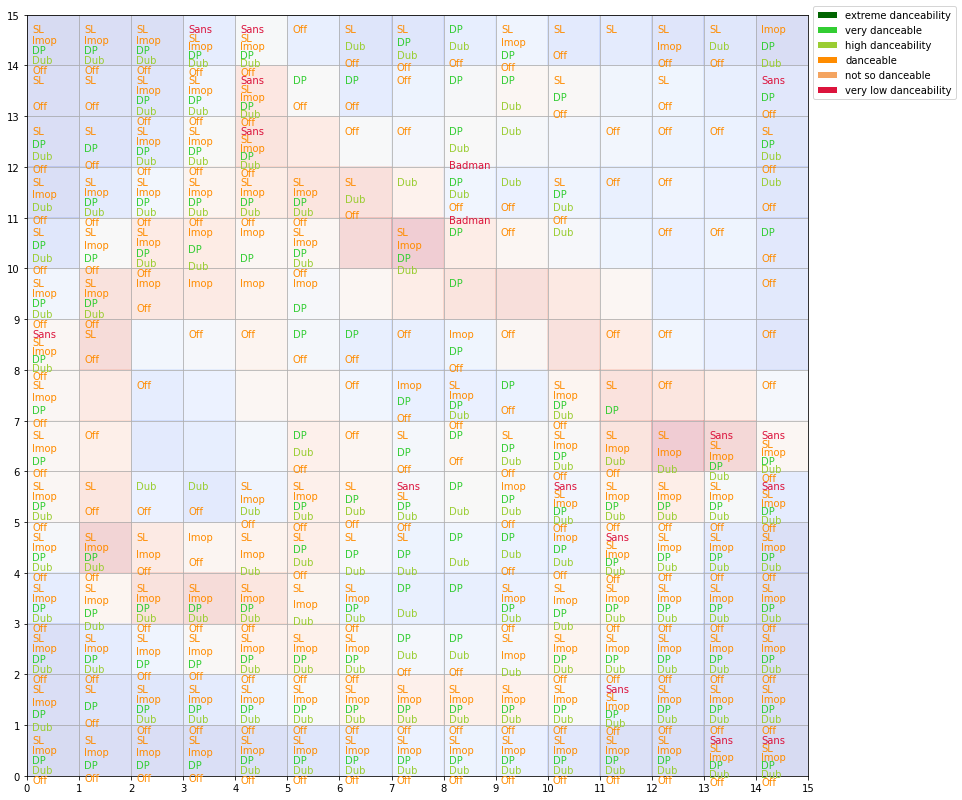

In [ ]:
def shorten_tracks(c):
    if len(c) > 6:
        return short_track[c]
    else:
        return c

dance_map = som.labels_map(X, data.track)
    
plt.figure(figsize=(14, 14))
for p, tracks in dance_map.items():
    countries = list(tracks)
    x = p[0] + .1
    y = p[1] - .3
    for i, c in enumerate(tracks):
        off_set = (i+1)/len(tracks) - 0.05
        plt.text(x, y+off_set, shorten_tracks(c), color=colors_dict[c], fontsize=10)
plt.pcolor(som.distance_map().T, cmap='coolwarm', alpha=.2)
plt.xticks(np.arange(size+1))
plt.yticks(np.arange(size+1))
plt.grid()

legend_elements = [Patch(facecolor=clr,
                         edgecolor='w',
                         label=l) for l, clr in category_color.items()]
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, .95))
plt.show()

#### 3.1.1.What really happens in SOM ?
Each data point in the data set recognizes themselves by competeting for representation. SOM mapping steps starts from initializing the weight vectors. From there a sample vector is selected randomly and the map of weight vectors is searched to find which weight best represents that sample. Each weight vector has neighboring weights that are close to it. The weight that is chosen is rewarded by being able to become more like that randomly selected sample vector. The neighbors of that weight are also rewarded by being able to become more like the chosen sample vector. This allows the map to grow and form different shapes. Most generally, they form square/rectangular/hexagonal/L shapes in 2D feature space.


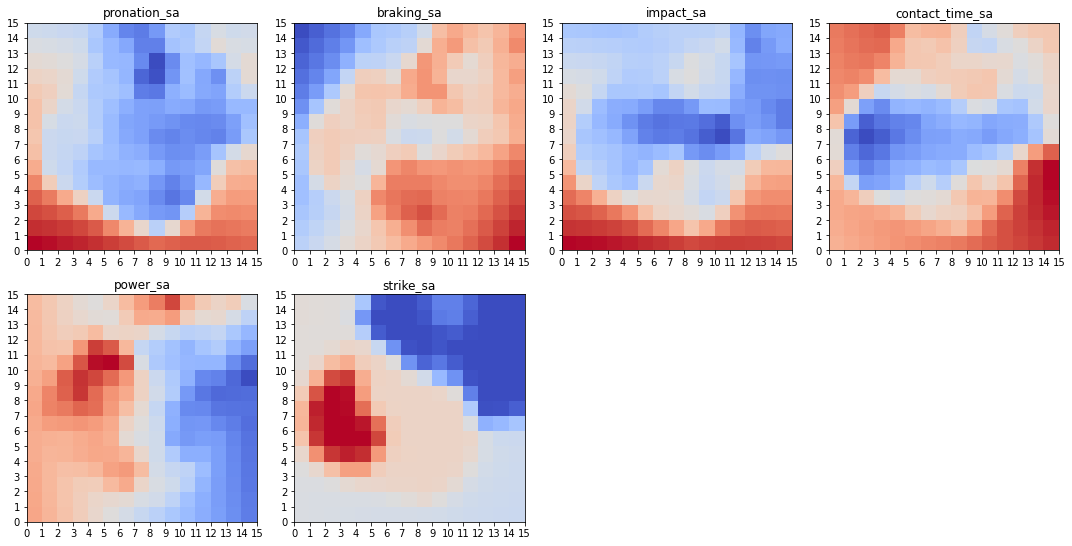

In [ ]:
W = som.get_weights()
plt.figure(figsize=(15, 15))
for i, f in enumerate(feature_names):
    plt.subplot(4, 4, i+1)
    plt.title(f)
    plt.pcolor(W[:,:,i].T, cmap='coolwarm')
    plt.xticks(np.arange(size+1))
    plt.yticks(np.arange(size+1))
plt.tight_layout()
plt.show()

# 4.Sources/Theory 

A self-organizing map (SOM) is a bit hard to describe. Briefly, a SOM is a data structure that allows you to investigate the structure of a set of data. If you have data without class labels, a SOM can indicate how many classes there are in the data. If you have data with class labels, a SOM can be used for dimensionality reduction so the data can be graphed, where the resulting graph indicates how similar different classes are.



Source: https://visualstudiomagazine.com/articles/2019/01/01/self-organizing-maps-python.aspx

Source: https://medium.com/@abhinavr8/self-organizing-maps-ff5853a118d4

# 4.1.Self Organizing Map Explained

If the average distance is high, then the surrounding weights are very different and a light color is assigned to the location of the weight. If the average distance is low, a darker color is assigned. The resulting maps show that the concentration of different clusters of species are more predominant in three zones. First figure tells us only about where the density of species is greater (darker regions) or less (lighter regions). The second visualisation tells us how they are specifically clustered.

**IN OTHER WORDS:** he darker parts represent clusters, while the lighter parts represent the division of the clusters.


# 5.Feature Plane

In this map we associate each neuron to the feature with the maximum weight. This segments our map in regions where specific features have high values.

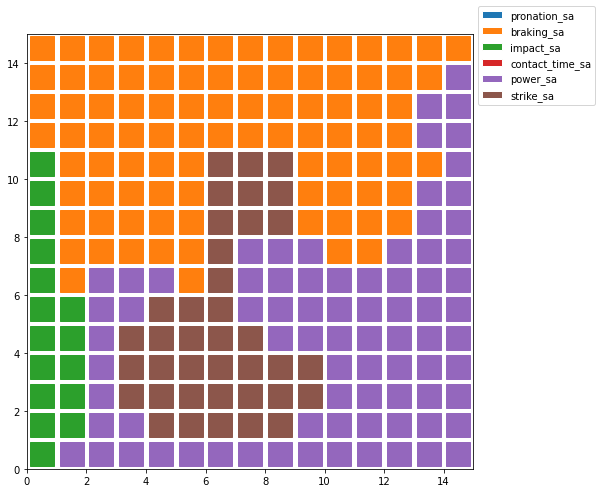

In [ ]:
Z = np.zeros((size, size))
plt.figure(figsize=(8, 8))
for i in np.arange(som._weights.shape[0]):
    for j in np.arange(som._weights.shape[1]):
        feature = np.argmax(W[i, j , :])
        plt.plot([j+.5], [i+.5], 'o', color='C'+str(feature),
                 marker='s', markersize=24)

legend_elements = [Patch(facecolor='C'+str(i),
                         edgecolor='w',
                         label=f) for i, f in enumerate(feature_names)]

plt.legend(handles=legend_elements,
           loc='center left',
           bbox_to_anchor=(1, .95))
        
plt.xlim([0, size])
plt.ylim([0, size])
plt.show()